In [19]:
import numpy as np
import pandas as pd
import ast
import time
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")
df = movies.merge(credits, on="title")

# dates
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year.fillna(0).astype(int)
df["release_month"] = df["release_date"].dt.month.fillna(0).astype(int)

# numeric clean
nums = ["budget","revenue","runtime","popularity","vote_count","vote_average"]
for col in nums:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["runtime"].fillna(df["runtime"].median(), inplace=True)
df["vote_average"].fillna(df["vote_average"].mean(), inplace=True)
df["log_vote_count"] = np.log1p(df["vote_count"])

# Actor and Director Scores
actor_scores = defaultdict(list)
director_scores = defaultdict(list)

for _, row in df[["cast","crew","vote_average"]].iterrows():
    rating = row["vote_average"]

    # Actors
    try:
        for c in ast.literal_eval(row["cast"]):
            if c.get("id"):
                actor_scores[c["id"]].append(rating)
    except:
        pass

    # Directors
    try:
        for p in ast.literal_eval(row["crew"]):
            if p.get("job") == "Director" and p.get("id"):
                director_scores[p["id"]].append(rating)
    except:
        pass

# Compute averages
global_mean = df["vote_average"].mean()
actor_avg = {k: np.mean(v) for k,v in actor_scores.items()}
director_avg = {k: np.mean(v) for k,v in director_scores.items()}

# Actor + Director Features
def extract_simple_features(row):
    # Top 3 actors
    try:
        cast = sorted(ast.literal_eval(row["cast"]), key=lambda x: x.get("order", 999))[:3]
    except:
        cast = []

    cast_vals = [actor_avg.get(c.get("id"), global_mean) for c in cast]
    top_cast_score = np.mean(cast_vals) if cast_vals else global_mean
    top_cast_count = len(cast_vals)

    # Directors
    try:
        directors = [d.get("id") for d in ast.literal_eval(row["crew"]) if d.get("job")=="Director"]
    except:
        directors = []

    director_score = np.mean([director_avg.get(d, global_mean) for d in directors]) if directors else global_mean

    return pd.Series([top_cast_score, top_cast_count, director_score])

df[["top_cast_score","top_cast_count","director_score"]] = df.apply(extract_simple_features, axis=1)

# Final feature set
features = [
    "top_cast_score",
    "top_cast_count",
    "director_score",
    "log_vote_count",
]

X = df[features].fillna(0)
y = df["vote_average"]

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# NN Model
model = nn.Sequential(
    nn.Linear(4, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),

    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 96),
    nn.BatchNorm1d(96),
    nn.ReLU(),

    nn.Linear(96, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 48),
    nn.BatchNorm1d(48),
    nn.ReLU(),

    nn.Linear(48, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),

    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Linear(16, 8),
    nn.BatchNorm1d(8),
    nn.ReLU(),

    nn.Linear(8, 4),
    nn.ReLU(),

    nn.Linear(4, 1)
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 700
batch_size = 64
loss_history = []

loss_history = []
val_losses = []

print("\n===== TRAINING NEURAL NETWORK =====")
start = time.time()

for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(X_train_t.size(0))
    epoch_loss = 0.0

    # Mini-batch training
    for i in range(0, len(perm), batch_size):
        idx = perm[i:i+batch_size]
        batch_X = X_train_t[idx]
        batch_y = y_train_t[idx]

        preds = model(batch_X)
        loss = loss_fn(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= (len(perm) / batch_size)
    loss_history.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t).cpu().numpy().flatten()
        val_pred = np.clip(val_pred, 0, 10)   # Keep rating range 0–10
        val_loss = mean_squared_error(y_test, val_pred)
        val_losses.append(val_loss)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

end = time.time()
print("\nTraining time:", end - start, "seconds")

# Evaluation
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_t).cpu().numpy().flatten()
    y_test_pred = model(X_test_t).cpu().numpy().flatten()

# Clamp to 0–10 rating scale
y_train_pred = np.clip(y_train_pred, 0, 10)
y_test_pred = np.clip(y_test_pred, 0, 10)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTrain MSE: {train_mse:.4f} | Train R²: {train_r2:.4f}")
print(f"Test  MSE: {test_mse:.4f} | Test  R²: {test_r2:.4f}")


===== TRAINING NEURAL NETWORK =====
Epoch 50/700 | Train Loss: 0.3135 | Val Loss: 0.2971
Epoch 100/700 | Train Loss: 0.2774 | Val Loss: 0.2787
Epoch 150/700 | Train Loss: 0.2675 | Val Loss: 0.2469
Epoch 200/700 | Train Loss: 0.2668 | Val Loss: 0.2969
Epoch 250/700 | Train Loss: 0.2583 | Val Loss: 0.2343
Epoch 300/700 | Train Loss: 0.2558 | Val Loss: 0.2400
Epoch 350/700 | Train Loss: 0.2368 | Val Loss: 0.2325
Epoch 400/700 | Train Loss: 0.2282 | Val Loss: 0.2320
Epoch 450/700 | Train Loss: 0.2296 | Val Loss: 0.2277
Epoch 500/700 | Train Loss: 0.2187 | Val Loss: 0.2649
Epoch 550/700 | Train Loss: 0.2360 | Val Loss: 0.2520
Epoch 600/700 | Train Loss: 0.2396 | Val Loss: 0.2662
Epoch 650/700 | Train Loss: 0.2241 | Val Loss: 0.2319
Epoch 700/700 | Train Loss: 0.2445 | Val Loss: 0.2296

Training time: 1215.856505870819 seconds

Train MSE: 0.2058 | Train R²: 0.8588
Test  MSE: 0.2296 | Test  R²: 0.8229


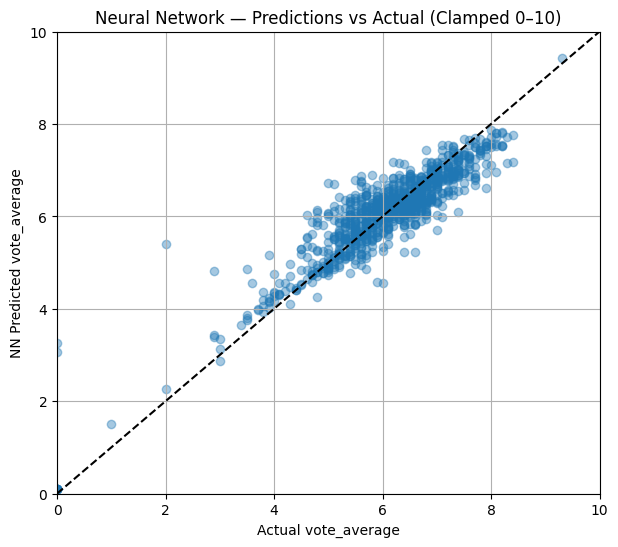

In [21]:
# Prediction Plot
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([0, 10], [0, 10], "k--")
plt.xlabel("Actual vote_average")
plt.ylabel("NN Predicted vote_average")
plt.title("Neural Network — Predictions vs Actual (Clamped 0–10)")
plt.xlim(0, 10.0)
plt.ylim(0, 10.0)
plt.grid(True)
plt.show()

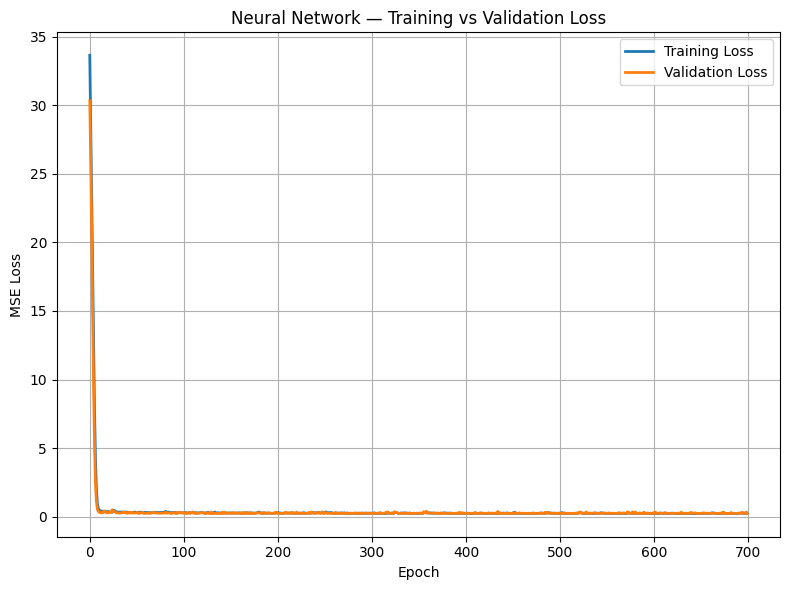

In [22]:
# Loss Plot
plt.figure(figsize=(8,6))
plt.plot(loss_history, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network — Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
def filter_by_actor_director(df, actor_name=None, director_name=None):
    filtered = df.copy()

    # Filter by actor
    if actor_name is not None:
        def has_actor(cast_str):
            try:
                cast_list = ast.literal_eval(cast_str)
                return any(member.get('name') == actor_name for member in cast_list)
            except:
                return False
        filtered = filtered[filtered['cast'].apply(has_actor)]

    # Filter by director
    if director_name is not None:
        def has_director(crew_str):
            try:
                crew_list = ast.literal_eval(crew_str)
                return any(member.get('job') == 'Director' and member.get('name') == director_name
                           for member in crew_list)
            except:
                return False
        filtered = filtered[filtered['crew'].apply(has_director)]

    return filtered

def find_actor_id(df, name):
    """Return TMDB actor ID given actor name."""
    name = name.lower()
    for cast_json in df["cast"]:
        try:
            for c in ast.literal_eval(cast_json):
                if c.get("name", "").lower() == name:
                    return c.get("id")
        except:
            pass
    return None


def find_director_id(df, name):
    """Return TMDB director ID given director name."""
    name = name.lower()
    for crew_json in df["crew"]:
        try:
            for m in ast.literal_eval(crew_json):
                if m.get("job") == "Director" and m.get("name", "").lower() == name:
                    return m.get("id")
        except:
            pass
    return None

def torch_predict(model, X):
    X_t = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        preds = model(X_t).cpu().numpy().flatten()
    return preds

def recommend_movies(df, model, scaler, user_pref, top_n=10):
    cand = df.copy()

    # Actor Filtering
    if "actor_name" in user_pref:
        actor_id = find_actor_id(df, user_pref["actor_name"])
        if actor_id is None:
            print(f"Actor '{user_pref['actor_name']}' not found.")
            return pd.DataFrame()

        def actor_in_movie(cast_json):
            try:
                cast = ast.literal_eval(cast_json)
                return any(c.get("id") == actor_id for c in cast)
            except:
                return False

        cand = cand[cand["cast"].apply(actor_in_movie)]

    # Dircetor Filtering
    if "director_name" in user_pref:
        director_id = find_director_id(df, user_pref["director_name"])
        if director_id is None:
            print(f"Director '{user_pref['director_name']}' not found.")
            return pd.DataFrame()

        def director_in_movie(crew_json):
            try:
                crew = ast.literal_eval(crew_json)
                return any(
                    m.get("job") == "Director" and m.get("id") == director_id
                    for m in crew
                )
            except:
                return False

        cand = cand[cand["crew"].apply(director_in_movie)]

    # Genre Filtering
    if "genre" in user_pref:
        genre = user_pref["genre"].lower()

        def has_genre(g_json):
            try:
                genres = ast.literal_eval(g_json)
                return any(g.get("name","").lower() == genre for g in genres)
            except:
                return False

        cand = cand[cand["genres"].apply(has_genre)]

    # Numeric Filters
    if "min_popularity" in user_pref:
        cand = cand[cand["popularity"].fillna(0) >= user_pref["min_popularity"]]

    if "min_vote_count" in user_pref:
        cand = cand[cand["vote_count"].fillna(0) >= user_pref["min_vote_count"]]

    if cand.shape[0] == 0:
        print("No movies matched the filters.")
        return pd.DataFrame()

    # Predict Ratings
    feature_cols = ["top_cast_score", "top_cast_count", "director_score", "log_vote_count"]
    X = cand[feature_cols].fillna(0)
    X_scaled = scaler.transform(X)

    cand["predicted_rating"] = np.clip(torch_predict(model, X_scaled), 0, 10)

    cand = cand.sort_values(
        by=["predicted_rating", "popularity"],
        ascending=[False, False]
    )

    return cand[["title", "predicted_rating", "vote_count", "popularity"]].head(top_n)

In [24]:
user_pref = {
    "actor_name": "Scarlett Johansson",
    "min_vote_count": 200
}
recs = recommend_movies(df, model, scaler, user_pref, top_n=10)
print(recs)

                                    title  predicted_rating  vote_count  \
1197                         The Prestige          7.697012        4391   
16                           The Avengers          7.604146       11776   
7                 Avengers: Age of Ultron          7.574620        6767   
1999                                  Her          7.394917        4097   
1154                                 Lucy          6.973223        5878   
26             Captain America: Civil War          6.852714        7241   
2475             Vicky Cristina Barcelona          6.807832        1020   
85    Captain America: The Winter Soldier          6.794459        5764   
79                             Iron Man 2          6.793027        6849   
2571                          Match Point          6.722437        1105   

      popularity  
1197   74.440708  
16    144.448633  
7     134.279229  
1999   53.682367  
1154  115.241998  
26    198.372395  
2475   32.758254  
85     72.225265  
79 